In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
g = nx.karate_club_graph()

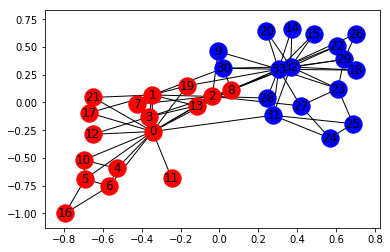

In [3]:
pos = nx.spring_layout(g)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_nodes(g, pos, node_color='r', nodelist=[
    k for k,v in nx.get_node_attributes(g, 'club').items() if v == 'Mr. Hi'])
nx.draw_networkx_nodes(g, pos, node_color='b', nodelist=[
    k for k,v in nx.get_node_attributes(g, 'club').items() if v == 'Officer'])
nx.draw_networkx_labels(g, pos)
plt.show()

In [4]:
X_train = np.zeros((len(g.nodes),2))
for k,v in g.nodes.items():
    X_train[k, 0 if v['club'] == 'Mr. Hi' else 1] = 1.
Y_train = np.copy(X_train)
Y_train[0::3,:] = 0.
Y_train[1::3,:] = 0.
print(f'{Y_train.shape[0]-np.sum(Y_train)}/{Y_train.shape[0]} labels are removed')

23.0/34 labels are removed


In [5]:
A = np.array(nx.adjacency_matrix(g).todense(), dtype=np.float)
A = A + np.identity(A.shape[0])
DI = np.diag(np.power(np.sum(A, axis=-1), -1/2))
A = DI @ A @ DI

In [6]:
class GraphConvolutional(keras.layers.Layer):
    
    def __init__(self, units, **kwargs):
        self.units = units
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            initializer='glorot_normal', name='kernel')
        super().build(input_shape)
    
    def call(self, inputs):
        H,A = inputs
        forward = A @ H
        forward = forward @ K.tile(
            K.expand_dims(self.kernel, axis=0),
            K.concatenate([K.shape(forward)[:1],
                K.constant(np.ones((2,)),dtype='int32')]))
        return forward
    
    def compute_output_shape(self, input_shape):
        return (*input_shape[0][:-1],self.units)

In [7]:
X = X_input_f = keras.layers.Input(X_train.shape)
X_input_a = keras.layers.Input(A.shape)
X = GraphConvolutional(32)([X, X_input_a])
X = keras.layers.Activation('relu')(X)
X = GraphConvolutional(32)([X, X_input_a])
X = keras.layers.Activation('relu')(X)
X = GraphConvolutional(Y_train.shape[-1])([X, X_input_a])
X = keras.layers.Activation('softmax')(X)
M = keras.Model([X_input_f, X_input_a], X)
M.compile('nadam', 'categorical_crossentropy')
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 34, 2)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 34, 34)       0                                            
__________________________________________________________________________________________________
graph_convolutional_1 (GraphCon (None, 34, 32)       64          input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 34, 32)       0           graph_convolutional_1[0][0]      
__________

In [8]:
M.fit([
    np.repeat(X_train[np.newaxis,...], 10000, axis=0),
    np.repeat(A[np.newaxis,...], 10000, axis=0)],
    np.repeat(Y_train[np.newaxis,...], 10000, axis=0), epochs=1)

Epoch 1/1
10000/10000 [==============================] - 2s 230us/step - loss: 0.0358


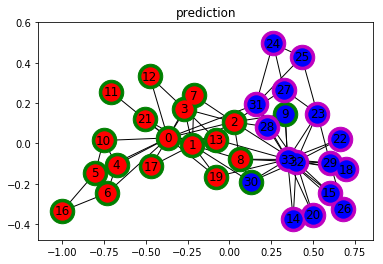

In [9]:
pred = M.predict([X_train[np.newaxis,...], A[np.newaxis,...]])[0]
pred = np.argmax(pred, axis=-1)
for i,p in enumerate(pred):
    g.node[i]['pred'] = p
plt.title('prediction')
pos = nx.spring_layout(g)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_nodes(g, pos, node_color='g', node_size=600, nodelist=[
    k for k,v in nx.get_node_attributes(g, 'pred').items() if v == 0])
nx.draw_networkx_nodes(g, pos, node_color='m', node_size=600, nodelist=[
    k for k,v in nx.get_node_attributes(g, 'pred').items() if v == 1])
nx.draw_networkx_nodes(g, pos, node_color='r', node_size=300, nodelist=[
    k for k,v in nx.get_node_attributes(g, 'club').items() if v == 'Mr. Hi'])
nx.draw_networkx_nodes(g, pos, node_color='b', node_size=300, nodelist=[
    k for k,v in nx.get_node_attributes(g, 'club').items() if v == 'Officer'])
nx.draw_networkx_labels(g, pos)
plt.show()